In [2]:
#importing the necessary libraries
import os
import numpy as np
import pandas as pd
import pathlib
import imageio
import matplotlib.pyplot as plt

In [3]:
# Exploring dataset
base_dir = '/content/drive/MyDrive/Chest X-Ray Images (Pneumonia)/'

train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total images:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total pneumonia images:",len(train_pn+test_pn+val_pn))
print ("Total Nomral images:",len(train_normal+test_normal+val_normal))


Total images: 5856
Total pneumonia images: 4273
Total Nomral images: 1583


In [4]:
# Dataset Splitting (train 80% , test 15% and validation 5% )

# Gathering all pneumina and normal chest X-ray in two python list
pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

# Spliting dataset in train set,test set and validation set.

train_imgs = pn[:3418]+ normal[:1224]  # 80% of 4273 Pneumonia and normal chest X-ray are 3418 and 1224 respectively.
test_imgs = pn[3418:4059]+ normal[1224:1502]
val_imgs = pn[4059:] + normal[1502:]

print("Total Train Images %s containing %s pneumonia and %s normal images" % (len(train_imgs),len(pn[:3418]),len(normal[:1224])))
print("Total Test Images %s containing %s pneumonia and %s normal images" % (len(test_imgs),len(pn[3418:4059]),len(normal[1224:1502])))
print("Total validation Images %s containing %s pneumonia and %s normal images" % (len(val_imgs),len(pn[4059:]),len(normal[1502:])))

import random

random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

Total Train Images 4642 containing 3418 pneumonia and 1224 normal images
Total Test Images 919 containing 641 pneumonia and 278 normal images
Total validation Images 295 containing 214 pneumonia and 81 normal images


In [5]:
import cv2
img_size = 224

def preprocess_image(image_list):

    X = [] # images
    y = [] #labels (0 for Normal or 1 for Pneumonia)
    count=0

    for image in image_list:

        try:

            img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)

            img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_CUBIC)

            #converting image to 2D to 3D
            img = np.dstack([img, img, img])

            #convrt greyscaling image to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Normalalizing Image
            img = img.astype(np.float32)/255.

            count=count+1

            X.append(img)


        except:
            continue
        #getting the labels
        if 'NORMAL' in image:
            y.append(0)

        elif 'IM' in image:
            y.append(0)

        elif 'virus' or 'bacteria' in image:
            y.append(1)


    return X, y

In [6]:
X, y = preprocess_image(train_imgs)

In [7]:
# Getting the labels for test set
P, t = preprocess_image(test_imgs)

In [8]:
# Getting the labels for validation set
K, m = preprocess_image(val_imgs)

In [9]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.unique(y), # here, y contains train set label
                                                  y = y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.8962418300653594, 1: 0.679052077238151}


In [10]:
import seaborn as sns
import gc

train_imgs = train_pn[:3875]+ train_normal[:1341]
del train_imgs
gc.collect()

X_train = np.array(X)
y_train = np.array(y)
X_test = np.array(P)
y_test = np.array(t)
X_val = np.array(K)
y_val = np.array(m)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(4642, 224, 224, 3)
(4642,)
(919, 224, 224, 3)
(919,)
(295, 224, 224, 3)
(295,)


In [11]:
# clearing memory
del X
del y
gc.collect()

#getting the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

batch_size = 32

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(  rotation_range=7,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     shear_range=0.2,
                                     zoom_range=0.45,
                                     horizontal_flip=True)

val_datagen = ImageDataGenerator(zoom_range=0.45)

In [13]:
#Creating the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [14]:
# Setting image Size
img_size =224

In [15]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras import backend as K

# Creating the base pre-trained model
# Weights should be none becuase we don't need to train with any pre-trained weights here

base_model = VGG16(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3))

x = base_model.output

# Adding a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Adding a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compiling model
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
# We can see details of  MobileNet architecure's details
# model.summary()

In [17]:
# We train for 64 epochs
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=64,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size,
                              class_weight =class_weights,
)

<ipython-input-17-f41a3383dd5e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/64
145/145 [==============================] - 105s 547ms/step - loss: 0.9619 - binary_accuracy: 0.3549 - val_loss: 0.6944 - val_binary_accuracy: 0.2743
Epoch 2/64
145/145 [==============================] - 79s 543ms/step - loss: 0.6935 - binary_accuracy: 0.3620 - val_loss: 0.6942 - val_binary_accuracy: 0.2812
Epoch 3/64
145/145 [==============================] - 81s 555ms/step - loss: 0.6925 - binary_accuracy: 0.2677 - val_loss: 0.6943 - val_binary_accuracy: 0.2778
Epoch 4/64
145/145 [==============================] - 82s 562ms/step - loss: 0.6926 - binary_accuracy: 0.6564 - val_loss: 0.6927 - val_binary_accuracy: 0.7257
Epoch 5/64
145/145 [==============================] - 80s 551ms/step - loss: 0.6931 - binary_accuracy: 0.3373 - val_loss: 0.6928 - val_binary_accuracy: 0.7222
Epoch 6/64
145/145 [==============================] - 80s 545ms/step - loss: 0.6933 - binary_accuracy: 0.7011 - val_loss: 0.6919 - val_binary_accuracy: 0.7222
Epoch 7/64
145/145 [=========================

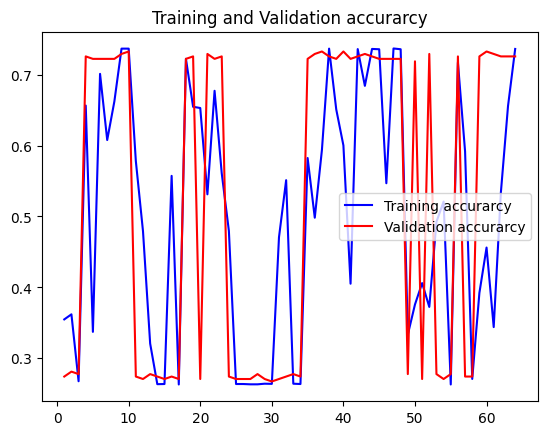

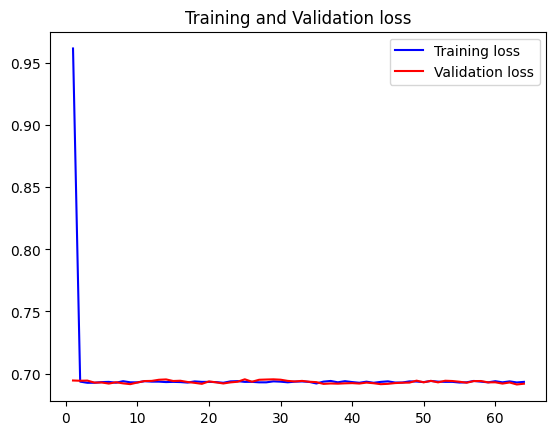

In [18]:
# Lets plot the train and val curve
# Getting the details form the history object
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Training and validating accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Training and validating loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

29/29 [==============================] - 7s 243ms/step
CONFUSION MATRIX ------------------
[[  0 278]
 [  0 641]]

============TEST METRICS=============
Accuracy: 69.74972796517955%
Precision: 69.74972796517955%
Recall: 100.0%
F1-score: 82.17948717948718

TRAIN METRIC ----------------------
Train acc: 73.62


<Axes: >

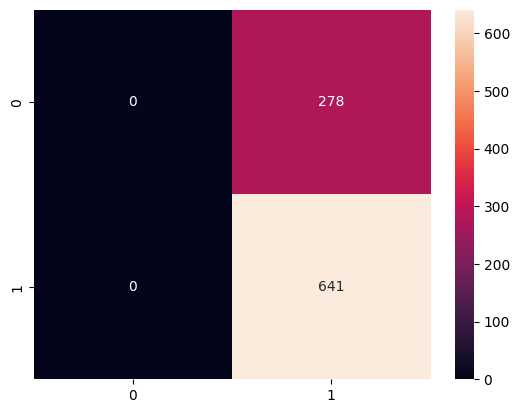

In [20]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

AUC Score: 0.5


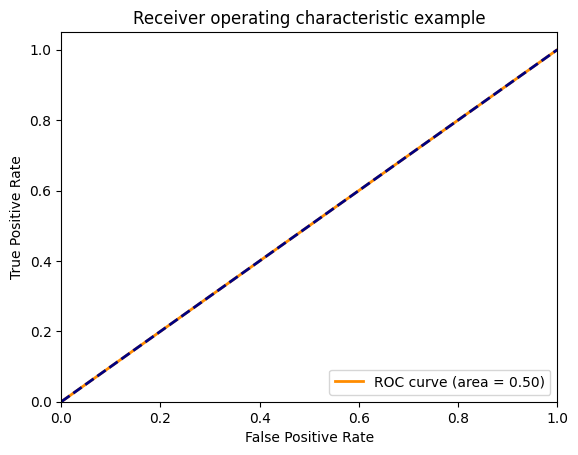

In [21]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()